In [53]:
import os

import altair as alt

import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [14]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B"
module = "encoder"
task = "rte"

In [15]:
# assertions
assert model == "bigscience-T0_3B"
assert module == "encoder"
assert task == "rte"

## Prompts

In [16]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


In [17]:
# load prompted inputs and labels
df_inputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_inputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/prompted_samples.csv", sep='\t', index_col=0)


In [18]:
df_inputs['gpt_3_cat_dog_with_targets'].head()

,input,label,prediction
0,"Dana Reeve, the widow of the actor Christopher Reeve, has died of lung cancer at age 44, according to the Christopher Reeve Foundation. Question: Christopher Reeve had an accident. Cat or Dog?",not_entailment,entailment
1,"Yet, we now are discovering that antibiotics are losing their effectiveness against illness. Disease-causing bacteria are mutating faster than we can come up with new antibiotics to fight the new variations. Question: Bacteria is winning the war against antibiotics. Cat or Dog?",entailment,not_entailment
2,"Cairo is now home to some 15 million people - a burgeoning population that produces approximately 10,000 tonnes of rubbish per day, putting an enormous strain on public services. In the past 10 years, the government has tried hard to encourage private investment in the refuse sector, but some estimate 4,000 tonnes of waste is left behind every day, festering in the heat as it waits for someone to clear it up. It is often the people in the poorest neighbourhoods that are worst affected. But in some areas they are fighting back. In Shubra, one of the northern districts of the city, the residents have taken to the streets armed with dustpans and brushes to clean up public areas which have been used as public dumps. Question: 15 million tonnes of rubbish are produced daily in Cairo. Cat or Dog?",not_entailment,entailment
3,"The Amish community in Pennsylvania, which numbers about 55,000, lives an agrarian lifestyle, shunning technological advances like electricity and automobiles. And many say their insular lifestyle gives them a sense that they are protected from the violence of American society. But as residents gathered near the school, some wearing traditional garb and arriving in horse-drawn buggies, they said that sense of safety had been shattered. ""If someone snaps and wants to do something stupid, there's no distance that's going to stop them,"" said Jake King, 56, an Amish lantern maker who knew several families whose children had been shot. Question: Pennsylvania has the biggest Amish community in the U.S. Cat or Dog?",not_entailment,not_entailment
4,"Security forces were on high alert after an election campaign in which more than 1,000 people, including seven election candidates, have been killed. Question: Security forces were on high alert after a campaign marred by violence. Cat or Dog?",entailment,not_entailment


In [19]:
# load decoded predictions
df_outputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_outputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/decoded_predictions.csv", sep='\t', names=['predicitons'])

In [59]:
df_outputs['gpt_3_cat_dog_with_targets'].tail()

,predicitons
272,"['<pad>', '▁Cat', '</s>']"
273,"['<pad>', '▁A', '▁dog']"
274,"['<pad>', '▁Dog', '</s>']"
275,"['<pad>', '▁Dog', '</s>']"
276,"['<pad>', '▁Dog', '</s>']"


## Plot t-SNE embeddings

In [21]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    # "mnli_crowdsource_with_targets",
    # "based_on_previous_passage_with_targets",
    # "infer_with_targets",
    # "follow_with_targets",
    # "imply_with_targets",
    # "guaranteed_with_targets",
    # "justified_with_targets",
    "must_be_true_with_targets",
    # "should_assume_with_targets",
    # "gpt_3_true_false_with_targets",
    # "gpt_3_cat_dog_with_targets",
    # "gpt_3_cat_dog_with_targets_yes_no",
    # "gpt_3_yes_no_without_targets",
    # "words_appear_with_targets",
    # "similar_words_with_targets",
    # "start_with_the_with_targets",
    # "same_meaning_with_targets",
    # "paraphrase_with_targets",
    # "paraphrase_r_with_targets",
    # "summarize_with_targets",
    # "inflection_with_targets",
    # "null_pattern_with_targets",
    # "null_pattern_r_with_targets",
    # "null_pattern_without_targets",
    # "null_pattern_r_without_targets",
    "premise_only_with_targets",
    # "premise_only_without_targets",
    "hypothesis_only_with_targets",
    # "hypothesis_only_without_targets",
]

In [22]:
# use either ground-truth or predicted label for marker size
# marker_size = 'ground-truth'
marker_size = 'predicted'

(1108, 2048)


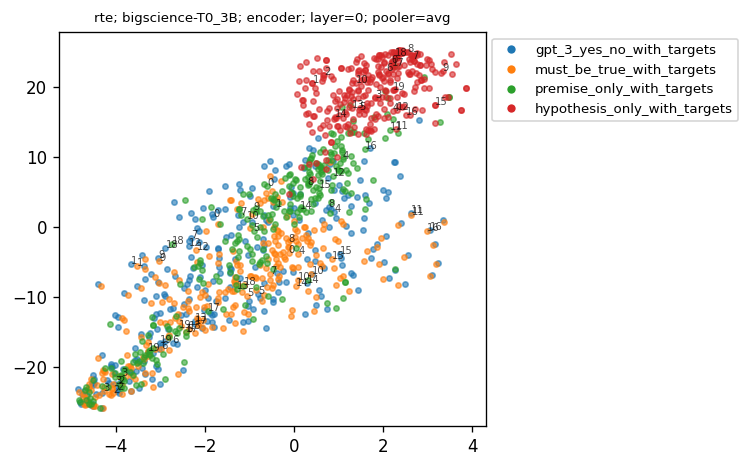

(1108, 2048)


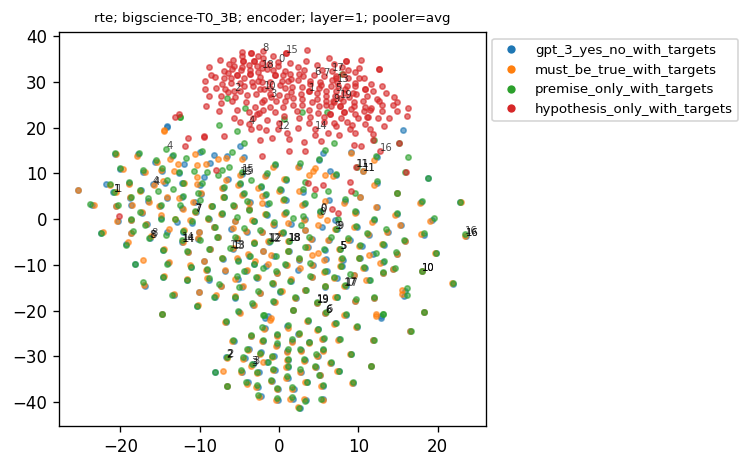

(1108, 2048)


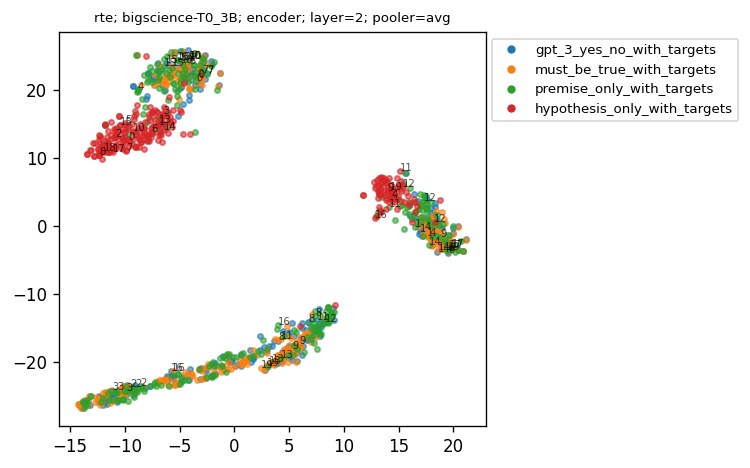

(1108, 2048)


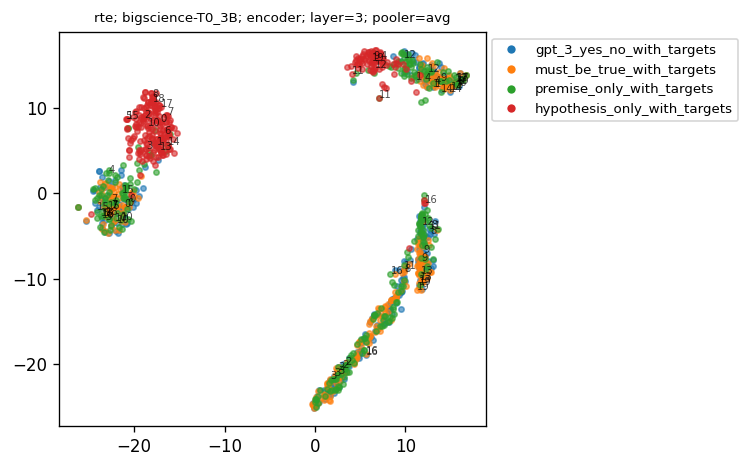

(1108, 2048)


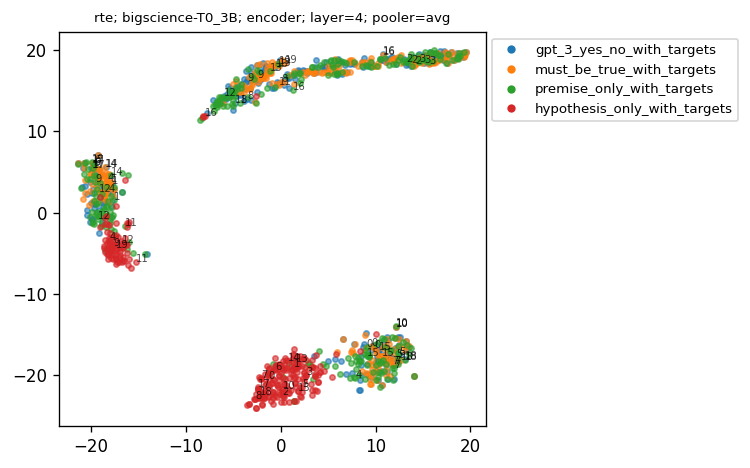

(1108, 2048)


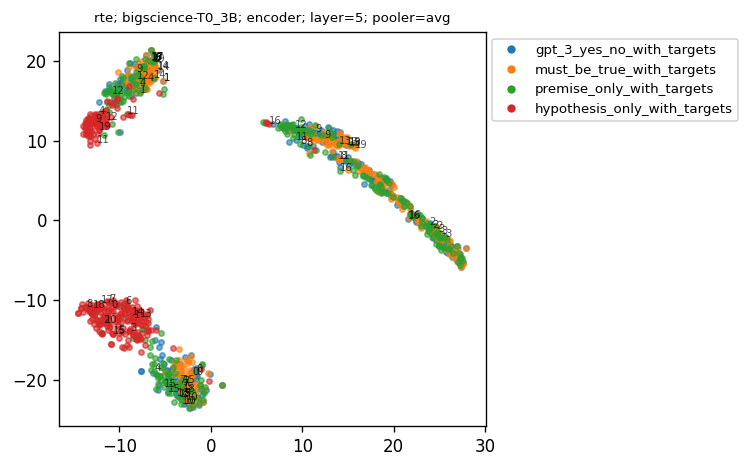

(1108, 2048)


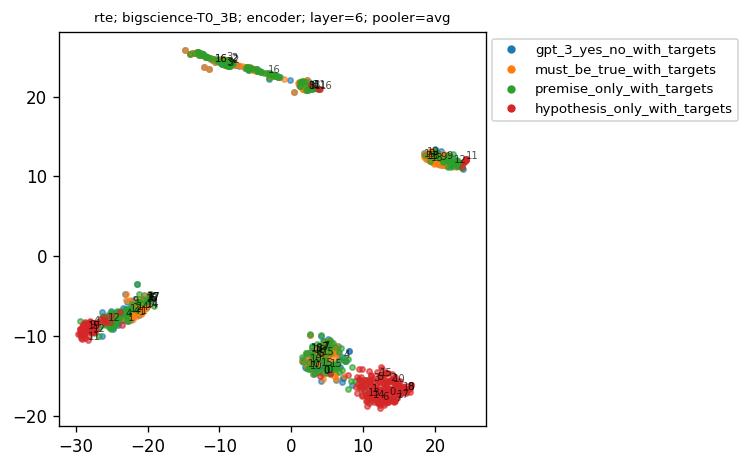

(1108, 2048)


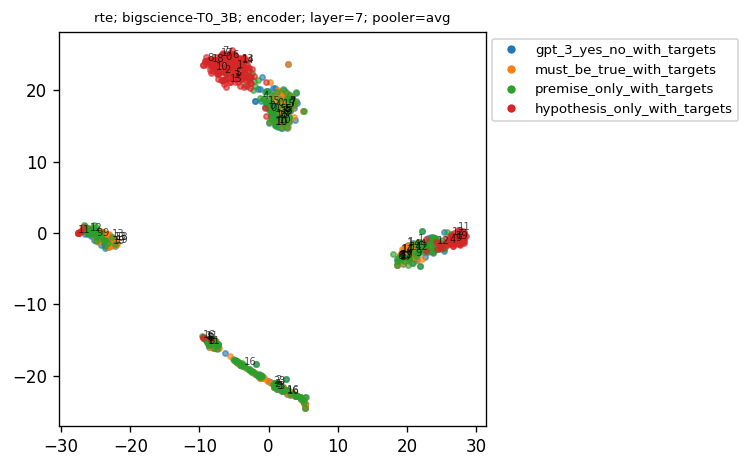

(1108, 2048)


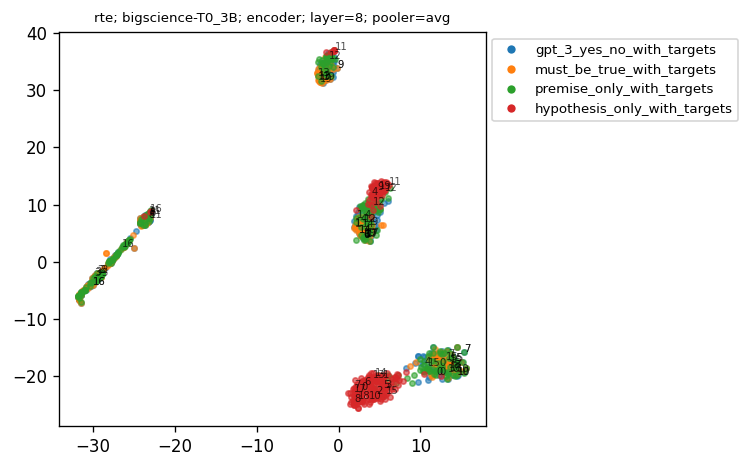

(1108, 2048)


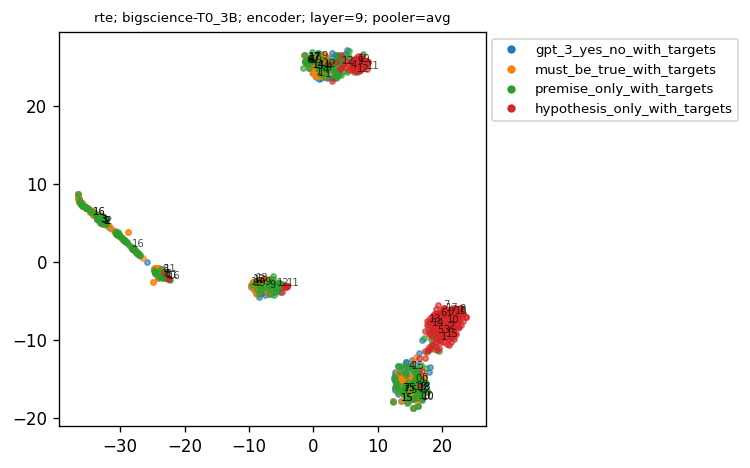

(1108, 2048)


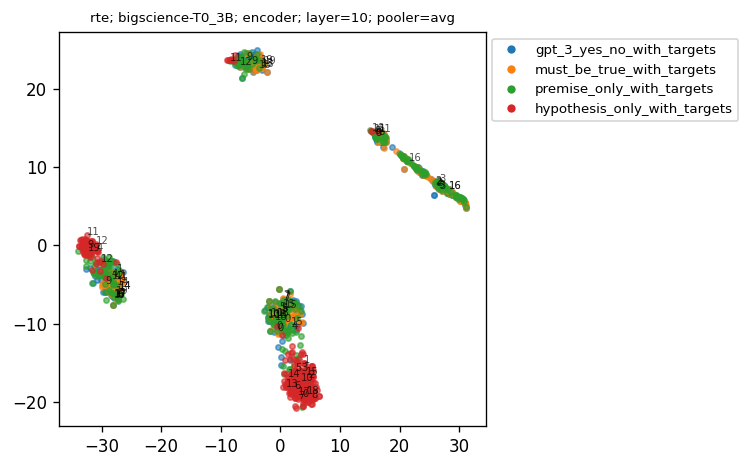

(1108, 2048)


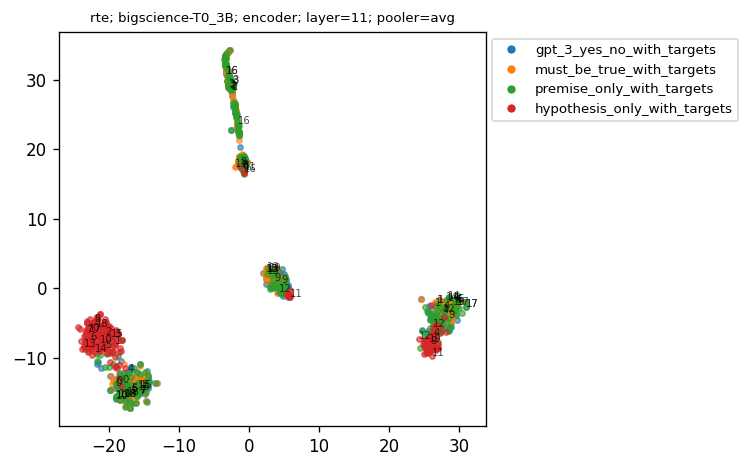

(1108, 2048)


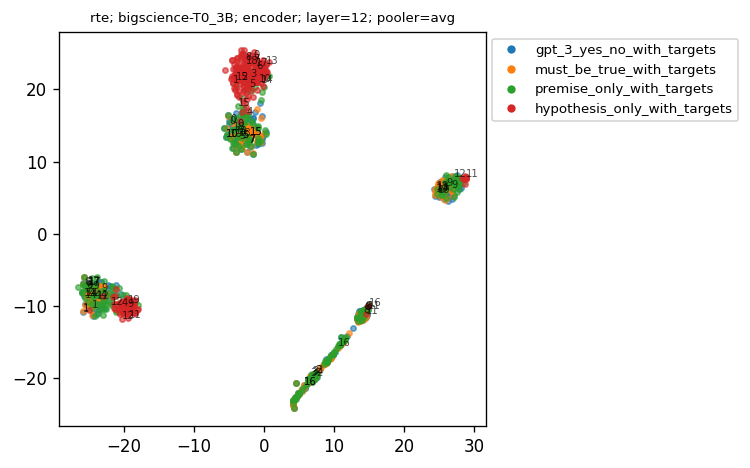

(1108, 2048)


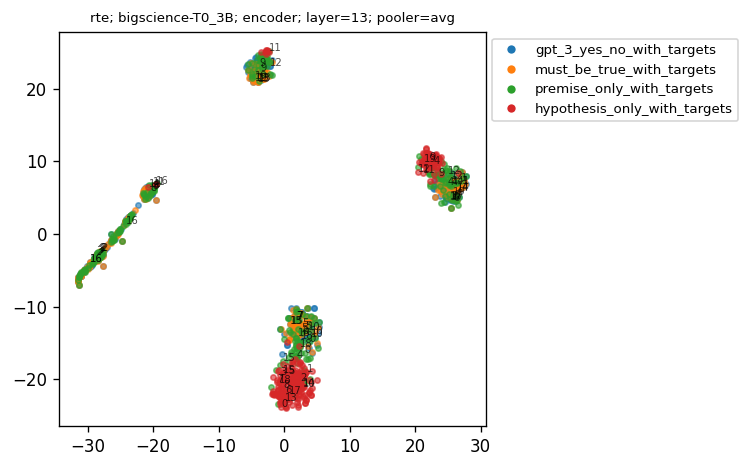

(1108, 2048)


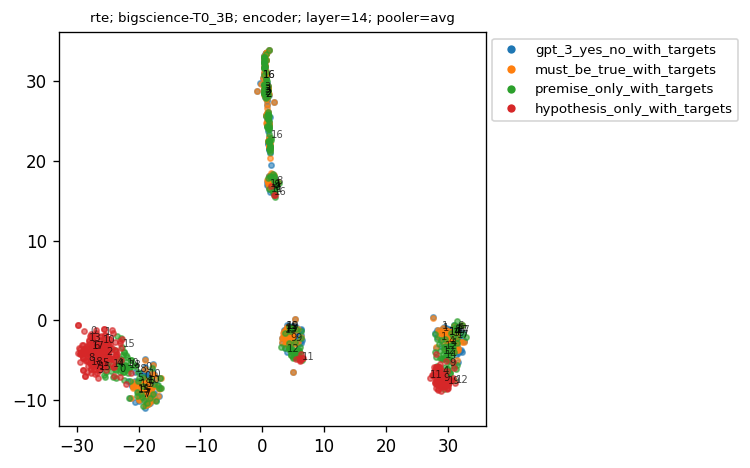

(1108, 2048)


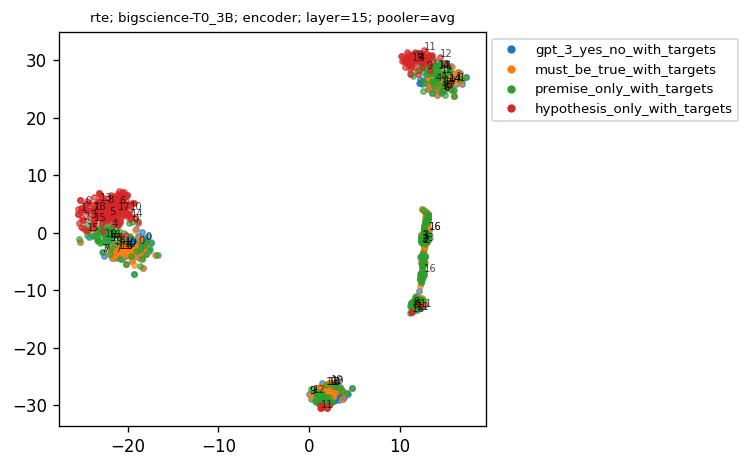

(1108, 2048)


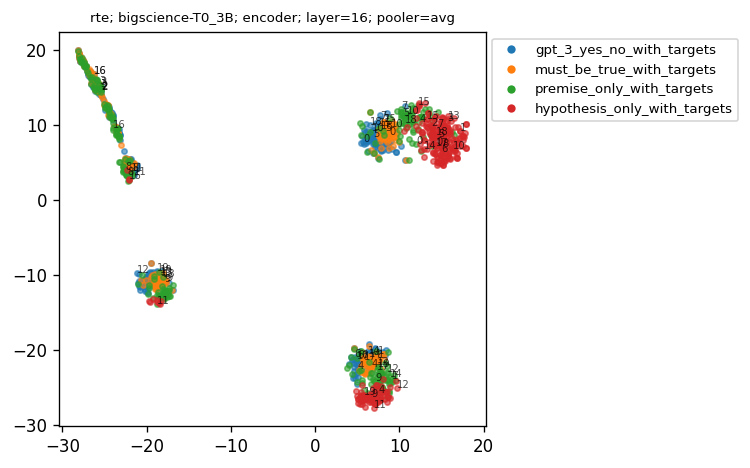

(1108, 2048)


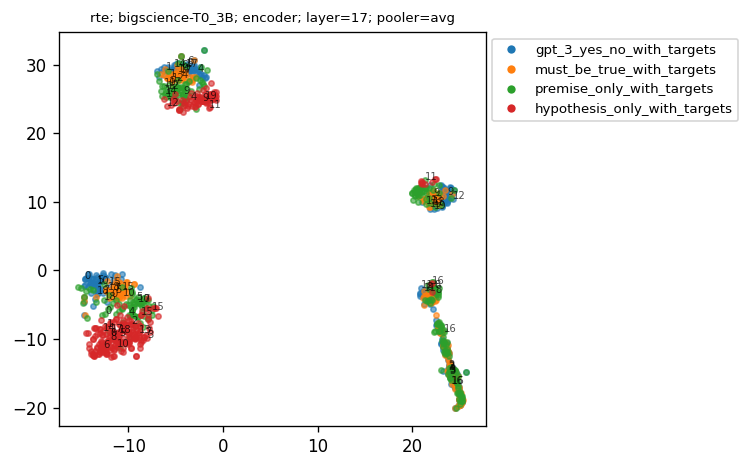

(1108, 2048)


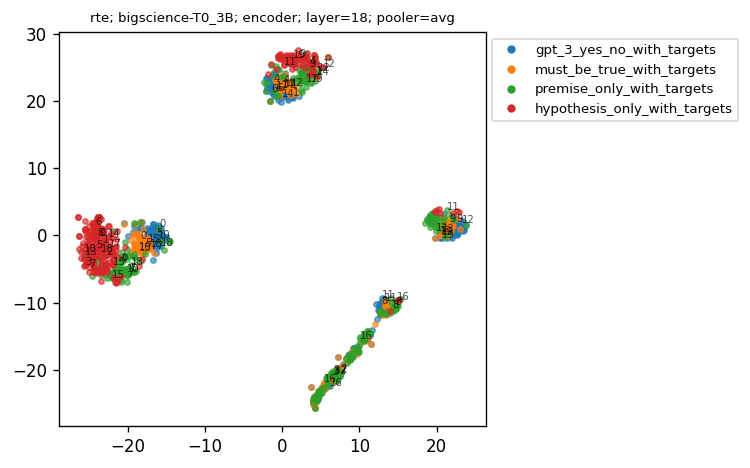

(1108, 2048)


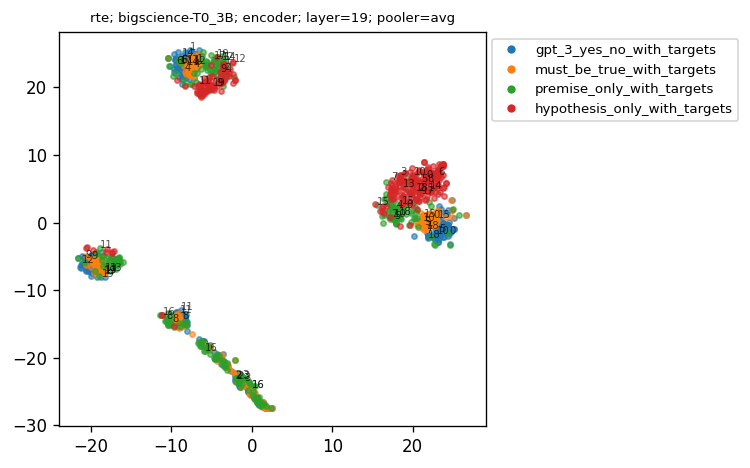

(1108, 2048)


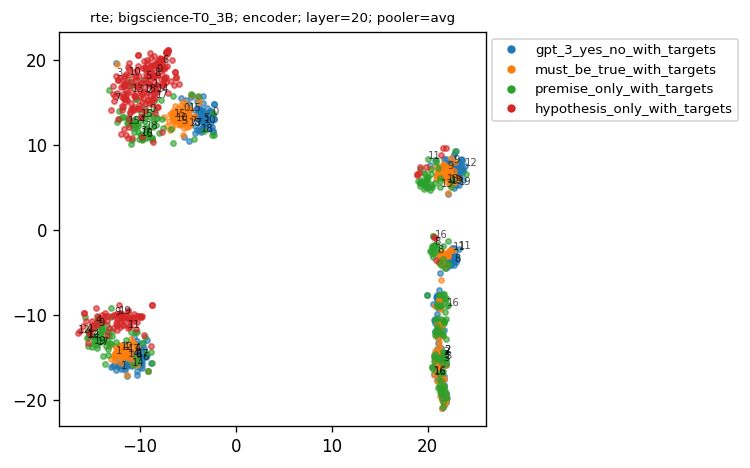

(1108, 2048)


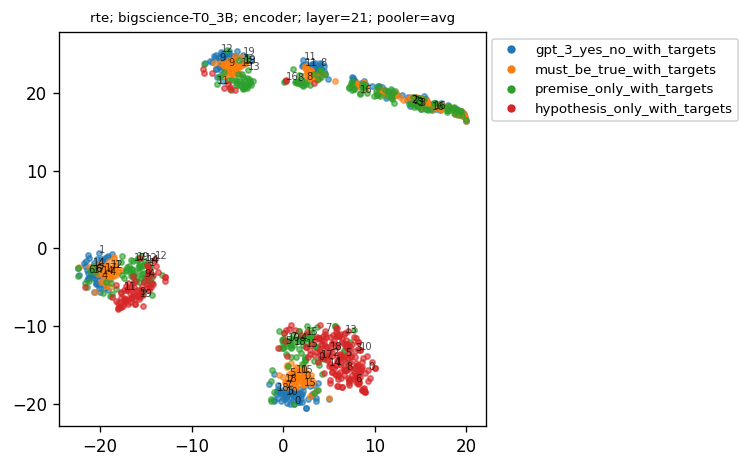

(1108, 2048)


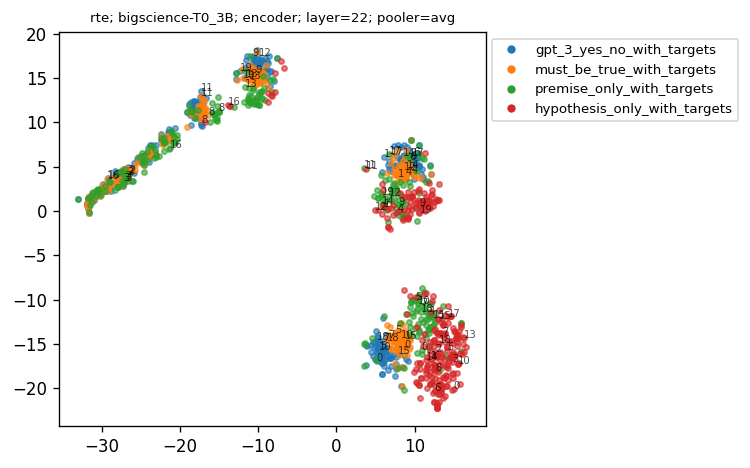

(1108, 2048)


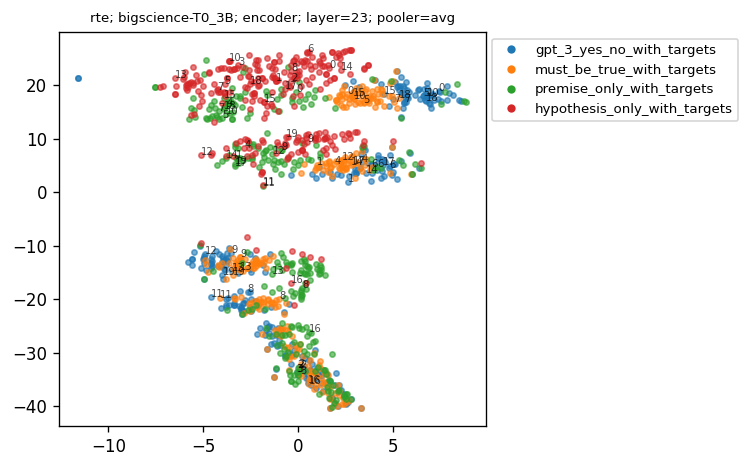

(1108, 2048)


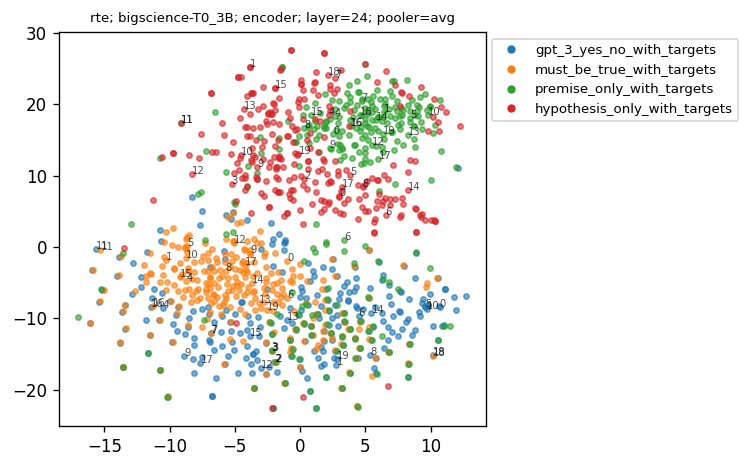

In [62]:
layer_dfs = {}

# for layer in range(0, 1):
# for layer in range(0, 5):
for layer in range(0, 25):
# for layer in range(24, 25):

    tsne_df = {"sid": [], "x": [], "y": [], "template": [], "text": [], "label": [], "prediction": [], "sequence": []}
    
    file_names, prompt_names = [], []
    
    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5")
            prompt_names.append(row['name'])
    
    # load hidden representations from hdf5 file
    representations = None
    n_sequences = 0

    for file_name in file_names:
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

    print(representations.shape)

    # compute t-SNE embeddings
    X = TSNE(
        n_components=2, 
        perplexity=100, 
        init='random', # random or pca
        learning_rate=200,
        n_iter=1000
    ).fit_transform(representations)

    # plot t-SNE embeddings
    fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=120)
    legend_elements= []

    cmap = matplotlib.cm.get_cmap('tab10')
    # cmap = matplotlib.cm.get_cmap('tab20')
    colors = cmap.colors

    for idx, file_name in enumerate(file_names):
        # create a scatter plot for samples from each pattern
        x, y = X[n_sequences*idx:n_sequences*(idx + 1), 0], X[n_sequences*idx:n_sequences*(idx + 1), 1]

        # change size according to label
        if marker_size == 'ground-truth':
            labels = df_inputs[prompt_names[idx]]['label'].values
            sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]
        elif marker_size == 'predicted':
            labels = df_inputs[prompt_names[idx]]['prediction'].values
            sizes = [40.0 if l == 'entailment' else 10.0 for l in labels]

        # axes.scatter(x, y, alpha=0.6, color=colors[idx], s=sizes)
        axes.scatter(x, y, alpha=0.6, color=colors[idx], s=[10.0]) # fix sizes

        # create legend element manually
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))

        # annotate scatter plot with text
        samles_indices = np.random.choice(range(n_sequences), size=20)
        # for i, txt in enumerate(list(range(n_sequences))): # annotate all samples
        # for i, txt in enumerate(samles_indices): # annotate randomly choosen samples
        for i, txt in enumerate(range(20)): # annotate first 10 samples
            axes.annotate(txt, (x[i], y[i]), alpha=0.7, fontsize=6)

        # collect data in dataframe
        for i in range(n_sequences):
            assert len(x) == n_sequences
            tsne_df["sid"].append(i)
            tsne_df["x"].append(x[i])
            tsne_df["y"].append(y[i])
            tsne_df["template"].append(prompt_names[idx])
            tsne_df["text"].append(df_inputs[prompt_names[idx]].iloc[i]["input"])
            tsne_df["label"].append(df_inputs[prompt_names[idx]]['label'].values[i])
            tsne_df["prediction"].append(df_inputs[prompt_names[idx]]['prediction'].values[i])
            tsne_df["sequence"].append(df_outputs[prompt_names[idx]].values[i])

    layer_dfs[layer] = pd.DataFrame(tsne_df)

    axes.set_title(f"{task}; {model}; {module}; layer={layer}; pooler=avg", fontsize=8)

   # Shrink current axis by 20%
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    # ground-truth labels
    # if marker_size == 'ground-truth':
    #     legend_elements.append(Line2D([0], [0], marker='o', color='w', label='entailment', markerfacecolor='gray', markersize=10))
    #     legend_elements.append(Line2D([0], [0], marker='o', color='w', label='not_entailment', markerfacecolor='gray', markersize=6))

    # # predicted labels
    # elif marker_size == 'predicted':
    #     legend_elements.append(Line2D([0], [0], marker='o', color='w', label='entailment (predicted)', markerfacecolor='gray', markersize=10))
    #     legend_elements.append(Line2D([0], [0], marker='o', color='w', label='not_entailment (predicted)', markerfacecolor='gray', markersize=6))
    
    axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

    plt.tight_layout()

    plt.show()
    plt.close();

## Create interactive altair plot for a single layer

In [64]:
LAYER = 20

source = layer_dfs[LAYER]
alt.Chart(source, title=f"t-SNE: {task}; {model}; {module}; layer={LAYER}; pooler=avg").mark_circle(size=60).encode(
    x='x',
    y='y',
    color='template',
    tooltip=['sid', 'text', 'label', 'prediction', 'sequence']
).properties(
    width=500,
    height=400
).interactive()

alt.Chart(...)